# Task 4
5390<br>
Elaina Rohlfing

# Load the data
* Upload & unzip the dataset
* Load training and validation images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
! rm -rf morel-dataset
! unzip -qq "/content/drive/MyDrive/Colab Notebooks/morel-dataset.zip"
! mv morel-dataset* morel-dataset

In [9]:
! ls -l morel-dataset/validation

total 8
drwxr-xr-x 2 root root 4096 May  3 04:57 morel
drwxr-xr-x 2 root root 4096 May  3 04:58 none


# Prepare the images (training and validation)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def get_images(image_size=(256, 256), size_of_batch=32):
    # Rescale all images
    img_generator = ImageDataGenerator(rescale=1./255)

    tr = img_generator.flow_from_directory( "./morel-dataset/train", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    val = img_generator.flow_from_directory( "./morel-dataset/validation", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    tst = img_generator.flow_from_directory( "./morel-dataset/test", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    return tr, val, tst


# Review details of dataset
def print_data_characteristics(data):
    print(f'{data.class_indices=}')
    print(f'{data.num_classes=}')
    print(f'{data.batch_size=}')
    print(f'{data.samples=}')
    print(f'{data.image_shape=}')
    imgs, lbls = data[0]
    print(f'{lbls.shape=}')
    print(f'{lbls=}')

    # check baseline accurracy (for majority class in binary classification)
    num_class0 = data.classes[data.classes == 0].size
    num_class1 = data.classes[data.classes == 1].size
    class1_relative_size = (100 * (num_class1/(num_class0 + num_class1)))
    class0_relative_size = (100 - class1_relative_size)
    if class1_relative_size > class0_relative_size:
        print(f'\nMajority class is class[1]\nBaseline accuracy for this dataset is: {class1_relative_size:.2f}%')
    else:
        print(f'\nMajority class is class[0]\nBaseline accuracy for this dataset is: {class0_relative_size:.2f}%')


# Displays one image and its label
def display_image(dataset, img_index=0, batch_index=0):
    images, labels = dataset[batch_index]
    class_index = int(labels[img_index])
    classes = list(dataset.class_indices.keys())

    plt.imshow(images[img_index])
    plt.title(f"Ground truth: {str(labels[img_index])}\n{classes[class_index]}") # add name of label train_ds.class_indices
    plt.axis("off")

# Displays multiple random images in a grid
def plot_image_grid(image_gen, batch_number=0, num_images=6, num_rows=2):
    indices = np.random.choice(image_gen.batch_size, size=num_images, replace=False)
    plt.figure(figsize=(12, 8))
    for i, img_idx in enumerate(indices):
        plt.subplot(num_rows, (len(indices) + 1) // num_rows, i + 1)
        display_image(image_gen, img_idx, batch_number)
    plt.tight_layout()
    plt.show()
    print_data_characteristics(image_gen)

In [55]:
train_set, val_set, test_set = get_images()

Found 552 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


**Display images with their labels**

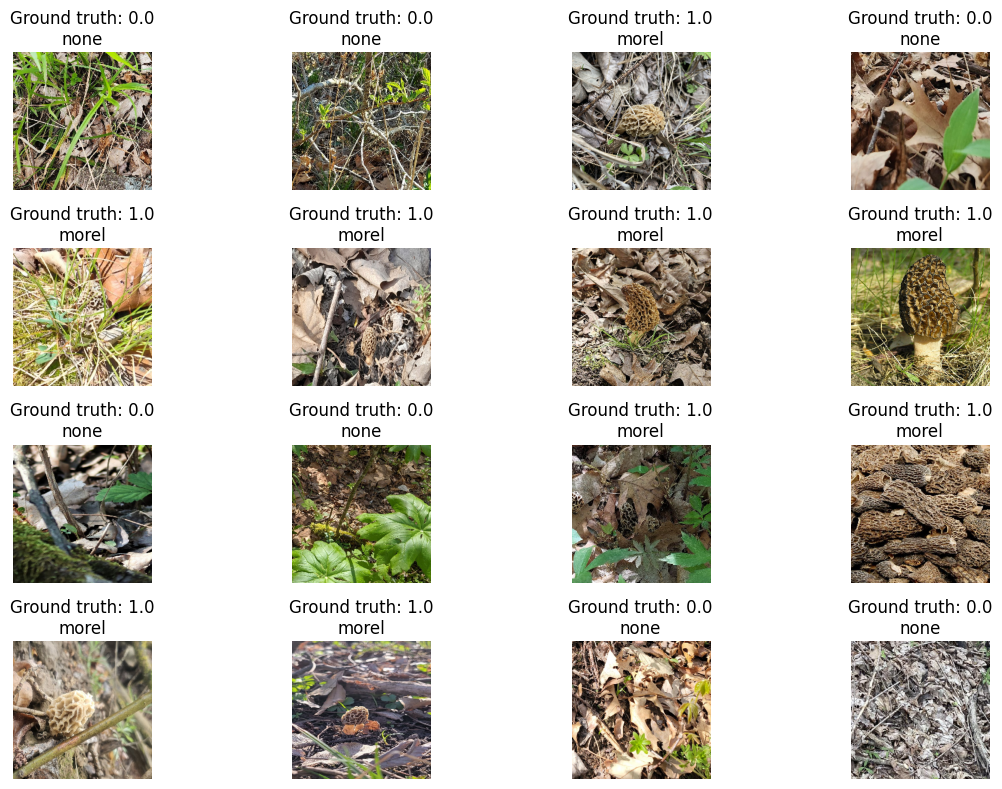

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=32
data.samples=552
data.image_shape=(256, 256, 3)
lbls.shape=(32,)
lbls=array([1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [56]:
plot_image_grid(train_set, num_images=16, num_rows=4)

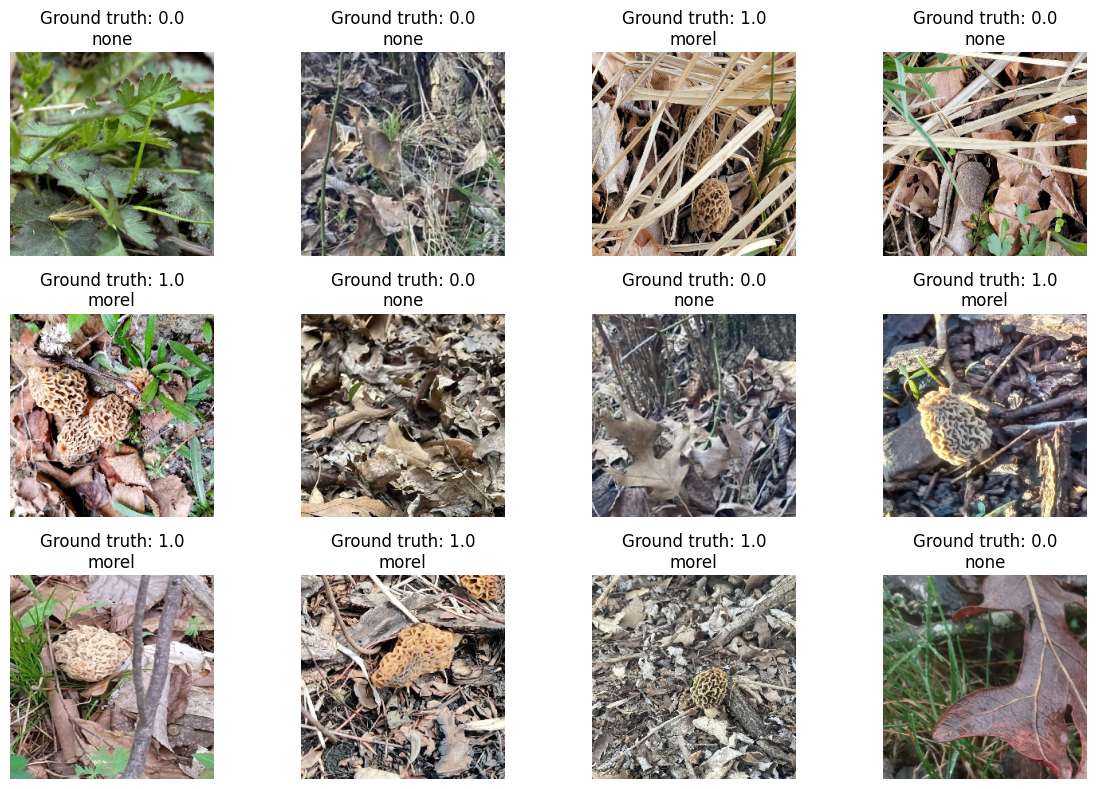

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=32
data.samples=160
data.image_shape=(256, 256, 3)
lbls.shape=(32,)
lbls=array([1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [22]:
plot_image_grid(val_set, num_images=12, num_rows=3)

# Functions

## Plot learning curves

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_learning_curves(hist, title, validate=False):
    fig, axs = plt.subplots(2, 1, figsize=(6, 7))
    epochs = range(1, len(hist.history['loss']) + 1)

    if validate:
        axs[0].plot(epochs, hist.history['val_accuracy'], marker='o', markersize=3, linestyle='', label='Validation Accuracy')
    axs[0].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    axs[0].set_title("Accuracy for " + title)
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    if validate:
        axs[1].plot(epochs, hist.history['val_loss'], marker='o', markersize=3, linestyle='', label='Validation Loss')
    axs[1].plot(epochs, hist.history['loss'], label='Training Loss')
    axs[1].set_title("Loss for " + title)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_multiple_history(histories, history_labels, title):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

    colors = list([color for color, rgb in mcolors.CSS4_COLORS.items() if mcolors.rgb_to_hsv(mcolors.to_rgba(rgb)[:3])[2] < 0.9])

    # Plot training and validation accuracy
    for i, h in enumerate(histories):
        axs[0].plot(h.history['accuracy'], label=f'Train Acc {history_labels[i]}', color=colors[i])
        axs[0].plot(h.history['val_accuracy'], label=f'Val Acc {history_labels[i]}', color=colors[i], marker='o', markersize=3, linestyle='')
    axs[0].set_title(f'Accuracy - Model {i+1}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    # Plot training and validation loss
    for i, h in enumerate(histories):
        axs[1].plot(h.history['loss'], label=f'Train Loss {history_labels[i]}', color=colors[i])
        axs[1].plot(h.history['val_loss'], label=f'Val Loss {history_labels[i]}', color=colors[i], marker='o', markersize=3, linestyle='')
    axs[1].set_title(f'Loss - Model {i+1}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## View Predictions

In [14]:
# modified code from chatgpt
def plot_misclassified_images(model, data_generator, num_images_per_class=4):
    images, true_labels = data_generator.next()
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten().astype(int)  # Round predictions for binary classification

    misclassified_indices = np.where(predicted_labels != true_labels)[0][:10]
    misclassified_morel = np.where((predicted_labels == 1) & (predicted_labels != true_labels))[0][:]
    misclassified_none = np.where((predicted_labels == 0) & (predicted_labels != true_labels))[0][:]

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(misclassified_none):
        image = images[idx]
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if i == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 8))
    for j, idx in enumerate(misclassified_morel):
        image = images[idx]
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, j + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if j == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

In [ ]:
# modified code from chatgpt
def plot_successful_predictions(model, data_generator, num_images_per_class=4):
    images, true_labels = data_generator.next()
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten().astype(int)  # Round predictions for binary classification

    classified_indices = np.where(predicted_labels == true_labels)[0][:]
    classified_morel = np.where((predicted_labels == 1) & (predicted_labels == true_labels))[0][:]
    classified_none = np.where((predicted_labels == 0) & (predicted_labels == true_labels))[0][:]

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(classified_none):
        image = images[idx]  # Get the image from the generator
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if i == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    for j, idx in enumerate(classified_morel):
        image = images[idx]  # Get the image from the generator
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, j + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if j == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

## Check activations

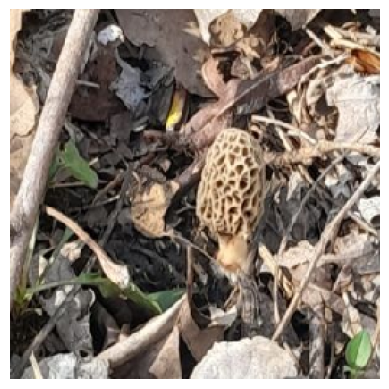

(1, 256, 256, 3)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np


def get_img_array(img_path, target_size):
    image = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    return array

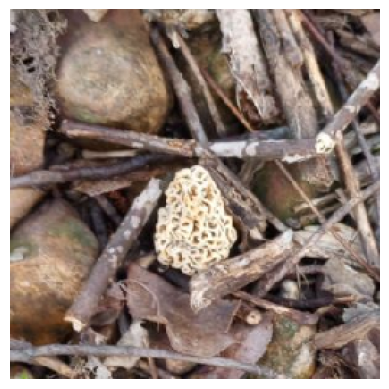

1/1 [==============================] - 0s 19ms/step


array([[0.]], dtype=float32)

In [ ]:
img_tensor = get_img_array("/content/morel-dataset/train/morel/12930-16696-26633.jpg", target_size=(256, 256))

plt.imshow(img_tensor[0].astype('uint8'))
plt.axis('off')
plt.show()
img_tensor.shape

model.predict(img_tensor)


In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 27ms/step


(1, 256, 256, 6)


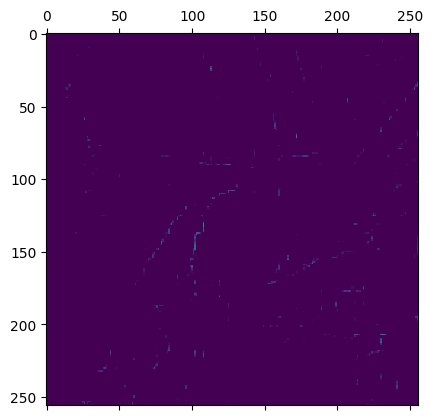

In [ ]:
import matplotlib.pyplot as plt

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

n_features=6 n_cols=3 size=256
n_features=6 n_cols=3 size=43
n_features=4 n_cols=2 size=43
n_features=4 n_cols=2 size=8
n_features=3 n_cols=1 size=8
n_features=3 n_cols=1 size=2
n_features=2 n_cols=1 size=2


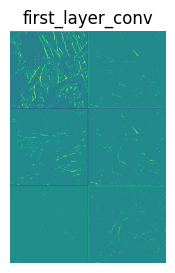

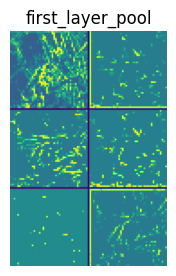

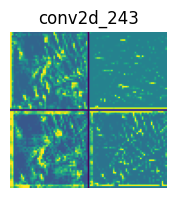

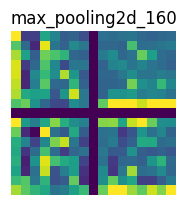

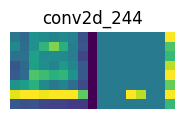

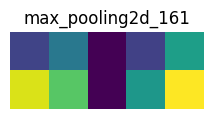

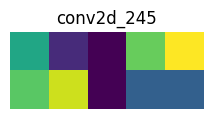

In [ ]:
images_per_row = 2
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = max(1, n_features // images_per_row)
    print(f'{n_features=} {n_cols=} {size=}')
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[
                    col * (size + 1): (col + 1) * size + col,
                    row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Visualize filters

# Regularizing a model with augmented data

### Some model builds

In [115]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

def very_deep_dropout(input, starting_filters=16, num_blocks=3):
    pool = 6
    kernel = 3
    pad = 'same'
    drop = .3
    num_filters = starting_filters

    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.08),
            layers.RandomZoom(0.15),
            layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(.1)
        ]
    )

    inputs = keras.Input(shape=input.image_shape)
    x = data_augmentation(inputs)

    for i in range(num_blocks):
        num_filters += 8*i
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters=num_filters, kernel_size=kernel, activation="relu", padding=pad)(x)
        x = layers.Dropout(drop)(x)
        x = layers.Conv2D(filters=num_filters, kernel_size=kernel, activation="relu", padding=pad)(x)
        x = layers.Conv2D(filters=num_filters, kernel_size=kernel, activation="relu", padding=pad)(x)
        x = layers.MaxPooling2D(pool_size=pool, padding=pad)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(num_filters // num_blocks, activation='relu')(x)
    x = layers.Dense(num_blocks, activation='relu')(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="very_deep_dropout")
    return model

## Training

In [116]:
model = very_deep_dropout(train_set)
model.summary()

Model: "very_deep_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 batch_normalization_78 (Ba  (None, 256, 256, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_246 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 dropout_77 (Dropout)        (None, 256, 256, 16)      0         
                                                                 
 conv2d_247 (Conv2D)         (None, 256, 256, 16)      2320      
                                                 

In [97]:
from tensorflow.keras import callbacks
# general callback for all models
cb_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=20)

In [117]:
num_epochs = 150
batch=64
model.summary()

# image callbacks
# set filepath for checkpointing
model_filename = f"{model.name}_aug_reg.hg5"
cb_checkpoint = callbacks.ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor="val_loss")

# compile and fit
print(f'Training model {model.name}')
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, validation_data=val_set, epochs=num_epochs, batch_size=batch, callbacks=[cb_checkpoint, cb_stopping])

Model: "very_deep_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 batch_normalization_78 (Ba  (None, 256, 256, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_246 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 dropout_77 (Dropout)        (None, 256, 256, 16)      0         
                                                                 
 conv2d_247 (Conv2D)         (None, 256, 256, 16)      2320      
                                                 